In [1]:
import sys
sys.executable

'/home/sh0416/anaconda3/envs/sentence-benchmark/bin/python'

In [2]:
import os
rootpath = os.path.abspath(os.path.join(os.getcwd(), os.path.pardir, os.path.pardir))

In [3]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(rootpath, "src")))
sys.path

['/home/sh0416/sentence-benchmark/src/notebooks',
 '/home/sh0416/anaconda3/envs/sentence-benchmark/lib/python38.zip',
 '/home/sh0416/anaconda3/envs/sentence-benchmark/lib/python3.8',
 '/home/sh0416/anaconda3/envs/sentence-benchmark/lib/python3.8/lib-dynload',
 '',
 '/home/sh0416/anaconda3/envs/sentence-benchmark/lib/python3.8/site-packages',
 '/home/sh0416/anaconda3/envs/sentence-benchmark/lib/python3.8/site-packages/IPython/extensions',
 '/home/sh0416/.ipython',
 '/home/sh0416/sentence-benchmark/src']

In [4]:
from transformers import RobertaModel
model = RobertaModel.from_pretrained("roberta-base")
model.eval()

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0): RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dropout): Drop

In [5]:
from transformers import RobertaTokenizer
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

In [6]:
from sentence_benchmark.data import load_sts12

In [7]:
sts12 = load_sts12(os.path.join(rootpath, "data/STS/STS12-en-test"))
sts12

{'MSRpar': [Example(input=['the problem likely will mean corrective changes before the shuttle fleet starts flying again .', 'he said the problem needs to be corrected before the space shuttle fleet is cleared to fly again .'], score=4.4),
  Example(input=['the technology-laced nasdaq composite index .ixic inched down 1 point , or 0.11 percent , to 1,650 .', "the broad standard & poor 's 500 index .spx inched up 3 points , or 0.32 percent , to 970 ."], score=0.8),
  Example(input=['" it \'s a huge black eye , " said publisher arthur ochs sulzberger jr . , whose family has controlled the paper since 1896 .', '" it \'s a huge black eye , " arthur sulzberger , the newspaper \'s publisher , said of the scandal .'], score=3.6),
  Example(input=['sec chairman william donaldson said there is a " building confidence out there that the cop is on the beat . "', '" i think there \'s a building confidence that the cop is on the beat . "'], score=3.4),
  Example(input=['vivendi shares closed 1.9 pe

In [8]:
import random
random.seed(0)
pos_example = sorted(list(filter(lambda x: x.score > 4, sts12["MSRpar"])), key=lambda x: len(x.input[0]))[0]
neg_example = sorted(list(filter(lambda x: x.score < 2, sts12["MSRpar"])), key=lambda x: len(x.input[0]))[0]

In [9]:
def get_inputs_and_outputs(example):
    inputs = tokenizer(example.input, padding=True, return_tensors='pt')
    outputs = model(**inputs)
    return inputs, outputs

pos_inputs, pos_outputs = get_inputs_and_outputs(pos_example)
neg_inputs, neg_outputs = get_inputs_and_outputs(neg_example)

In [10]:
import torch
import torch.nn.functional as F

def get_pairwise_sim(example, inputs, outputs):
    last_hidden_state1 = outputs.last_hidden_state[0]
    last_hidden_state2 = outputs.last_hidden_state[1]
    pairwise_sim = F.cosine_similarity(last_hidden_state1[:, None, :], last_hidden_state2[None, :, :], dim=2)
    
    attention_mask1 = inputs.attention_mask[0]
    attention_mask2 = inputs.attention_mask[1]
    pairwise_valid = torch.logical_and(attention_mask1[:, None], attention_mask2[None, :])

    input_length1 = attention_mask1.count_nonzero()
    input_length2 = attention_mask2.count_nonzero()
    pairwise_valid_sim = torch.masked_select(pairwise_sim, pairwise_valid).view(input_length1, input_length2)
    return pairwise_valid_sim

pos_pairwise_sim = get_pairwise_sim(pos_example, pos_inputs, pos_outputs)
neg_pairwise_sim = get_pairwise_sim(neg_example, neg_inputs, neg_outputs)

In [11]:
def get_input_strs(inputs):
    input_strs1 = list(filter(lambda x: x != "<pad>", tokenizer.convert_ids_to_tokens(inputs.input_ids[0])))
    input_strs2 = list(filter(lambda x: x != "<pad>", tokenizer.convert_ids_to_tokens(inputs.input_ids[1])))
    return input_strs1, input_strs2

pos_input_strs1, pos_input_strs2 = get_input_strs(pos_inputs)
neg_input_strs1, neg_input_strs2 = get_input_strs(neg_inputs)

In [12]:
pos_sentence1, pos_sentence2 = tokenizer.batch_decode(pos_inputs.input_ids)
neg_sentence1, neg_sentence2 = tokenizer.batch_decode(neg_inputs.input_ids)

<s>moore had no immediate comment tuesday.</s><pad><pad>
<s>in the united states, 20.7 percent of all women smoke.</s>


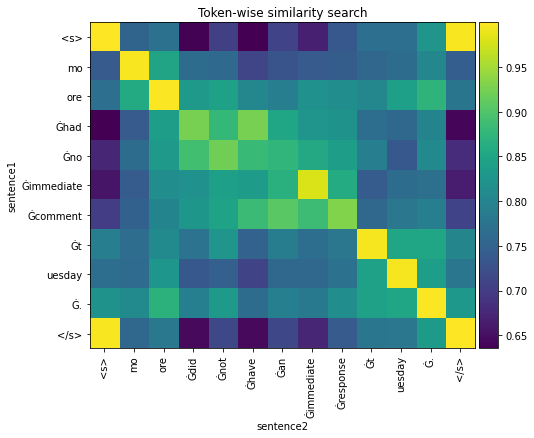

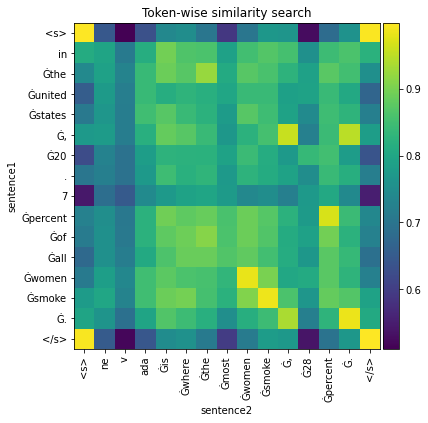

In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot(pairwise_sim, input_strs1, input_strs2):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_title("Token-wise similarity search")
    ax.set_ylabel("sentence1")
    ax.set_xlabel("sentence2")
    ax.set_yticks(range(len(input_strs1)))
    ax.set_yticklabels(input_strs1)
    ax.set_xticks(range(len(input_strs2)))
    ax.set_xticklabels(input_strs2, rotation=90)
    im = ax.imshow(pairwise_sim.detach().numpy())
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    
plot(pos_pairwise_sim, pos_input_strs1, pos_input_strs2)
plot(neg_pairwise_sim, neg_input_strs1, neg_input_strs2)
print(pos_sentence1)
print(neg_sentence1)